In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch import nn
from torchvision import models
from transformers import AutoModel
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import random
import warnings
from pathlib import Path
from tqdm import tqdm
import torch.optim as optim
from sklearn.model_selection import train_test_split

import sys
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


### Data Loading from the csv files

In [2]:
data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

train_data, valid_data = train_test_split(data, test_size=0.20, stratify=data.label)
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
14790,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12876,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35770,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10772,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6451,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(train_data.shape, valid_data.shape)

(33600, 785) (8400, 785)


### Dataloader with devices

In [5]:
class CustomDataset(Dataset):
    """ Custom dataset for `Digit Recognizer` """
    
    def __init__(self, inputs, targets, transform=None):
        self.inputs = inputs
        self.targets = targets
        self.transform = transform
        
        assert len(inputs) == len(targets), "Inputs and targets length have to be equal"
        
    def __len__(self):
        """ Return lenght """
        return len(self.inputs)
        
    def __getitem__(self, idx):
        """ Preprocess and return image with its label """
        image = self.inputs.values[idx].reshape(28, 28) / 255.0
        
        if self.transform is not None:
            image = self.transform(image)
            image = image.to(torch.float32)
        
        return image, self.targets[idx]

### Loading data

In [6]:
""" Preprocessing image """
data_transform = transforms.Compose([ 
    transforms.RandomRotation(degrees=15),
    transforms.Normalize((0.5,), (0.5,))
])

transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.Normalize((0.5,), (0.5,))
])


""" Params of DataLoaders """
num_workers = 2
pin_memory = True
batch_size = 128

""" Creating train dataset & loader """
train_dataset = CustomDataset(train_data.drop("label", axis=1), train_data["label"], transform2)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers=num_workers, pin_memory=pin_memory)

In [7]:
""" Creating valid dataset & loader """
valid_dataset = CustomDataset(valid_data.drop("label", axis=1), valid_data["label"], transform2)

valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

In [8]:
test_dataset = CustomDataset(valid_data.drop("label", axis=1), valid_data["label"], transform2)

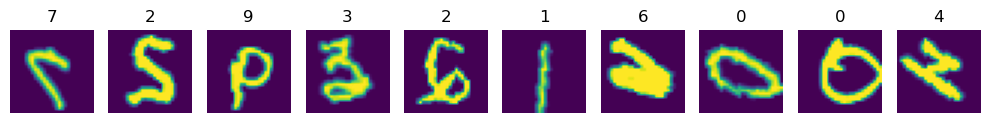

In [9]:
""" Show data """
n = 10
fig, axes = plt.subplots(1, n, figsize=(10, 20))

for i, idx in enumerate(random.sample(range(len(train_dataset)), n)):
    axes[i].imshow(train_dataset[idx][0].numpy().transpose(1, 2, 0))
    axes[i].set_title(train_dataset[idx][1])
    axes[i].axis("off")
    
plt.tight_layout()
plt.show()

#### Device loading the data

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
# def to_device(data, device):
#     """Move tensor(s) to chosen device"""
#     if isinstance(data, (list,tuple)):
#         return [to_device(x, device) for x in data]
#     return data.to(device, non_blocking=True)

# class DeviceDataLoader():
#     """Wrap a dataloader to move data to a device"""
#     def __init__(self, dl, device):
#         self.dl = dl
#         self.device = device
        
#     def __iter__(self):
#         """Yield a batch of data after moving it to device"""
#         for b in self.dl: 
#             yield to_device(b, self.device)

#     def __len__(self):
#         """Number of batches"""
#         return len(self.dl)

In [12]:
# train_dataloader = DeviceDataLoader(train_dataloader, device)
# valid_dataloader = DeviceDataLoader(valid_dataloader, device)

## **ResNet18 based Model**

In [13]:
# class ImageTransformerClassifier(nn.Module):
#     def __init__(self, model_name, num_classes):
#         super().__init__()
#         # Load a pre-trained CNN as a feature extractor
#         self.feature_extractor = models.resnet18(pretrained=True)
        
#         # Change the in_channels attribute of the first convolutional layer
#         self.feature_extractor.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
#         # Change the size of the average pooling layer
#         self.feature_extractor.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
#         self.feature_extractor.fc = nn.Identity()
        
#         # Load a pre-trained transformer model
#         self.transformer = AutoModel.from_pretrained(model_name)
        
#         # Project the output of the feature extractor to the transformer's hidden size
#         self.projection = nn.Linear(512, self.transformer.config.hidden_size)
        
#         # Add dropout and classification layers
#         self.dropout = nn.Dropout(0.1)
#         self.classifier = nn.Linear(self.transformer.config.hidden_size, num_classes)

#     def forward(self, images):
#         # Extract features from the images
#         features = self.feature_extractor(images)
        
#         # Project the features to the transformer's hidden size
#         projected_features = self.projection(features)
        
#         # Pass the projected features through the transformer
#         outputs = self.transformer(inputs_embeds=projected_features)
#         last_hidden_state = outputs.last_hidden_state
#         pooled_output = last_hidden_state[:, 0]
        
#         # Pass the output through dropout and classification layers
#         pooled_output = self.dropout(pooled_output)
#         logits = self.classifier(pooled_output)
        
#         return logits

# # Load a pre-trained transformer model from the Hugging Face Model Hub
# model_name = 'bert-base-uncased'
# num_classes = 10 # Number of classes for your classification task
# model = ImageTransformerClassifier(model_name, num_classes)


In [14]:
class SimpleClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Load a pre-trained resnet18 model
        self.model = models.resnet18(pretrained=True)
        # Load a pre-trained resnet50 model
        # self.model = models.resnet50(pretrained=True)
        
        # Change the first convolutional layer to accept grayscale images
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Change the size of the average pooling layer
        self.model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Change the last fully connected layer to output num_classes
        self.model.fc = nn.Linear(512, num_classes)
        # self.model.fc = nn.Linear(2048, num_classes)
    
    def forward(self, x):
        # Pass the input through the model
        x = self.model(x)
        return x

In [15]:
sim_model = SimpleClassifier()
sim_model = nn.DataParallel(sim_model)
sim_model.to(device)

# print(sim_model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


DataParallel(
  (module): SimpleClassifier(
    (model): ResNet(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1)

In [16]:
# model.to(device)
# print(model)

### Training and testing

In [17]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(sim_model.parameters(), lr=0.0001)
best_acc = 0.0
epochs = 10

loss_history = []
accuracy_history = { "train": [], "valid": [] }

OUTPUT_PATH = Path('/kaggle/working/weights')

# Train the model
for epoch in range(epochs):
    sim_model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    train_loss = []
    
    train_bar = tqdm(train_dataloader)
    for images, labels in train_bar:
        # train block
        optimizer.zero_grad()
        images = images.to(device)
        images2 = data_transform(images)
        images2 = images.to(device)
        labels = labels.to(device)
        logits = sim_model(images)
        logits2 = sim_model(images2)
        
        loss1 = criterion(logits, labels)
        loss2 = criterion(logits2, labels)
        loss = (loss1 + loss2)/2
        #loss += model.get_regularization(loss * 0.5, loss * 0.5)
        loss.backward()
        optimizer.step()
                
        # stat calculate block
        total_loss += loss.item()
        train_loss.append(loss.item())
        train_bar.set_description(f"Training [{epoch+1}/{epochs}] loss: {np.mean(train_loss):.5f}")
        
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
        loss_history.append(total_loss / len(train_dataloader))
        accuracy_history["train"].append(correct / total)
            
    if valid_dataloader is not None:
        
        sim_model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            
            valid_bar = tqdm(valid_dataloader)
            
            for images, labels in valid_bar:
                images = images.to(device)
                labels = labels.to(device)
                outputs = sim_model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                valid_bar.set_description(f"Validation [{epoch+1}/{epochs}] accuracy: {np.mean(correct/total)*100:.5f}")
            
            acc = correct/total
            if acc > best_acc:
                file_path = OUTPUT_PATH / f"bb_resnet18_{best_acc:.5f}.pth"
                if os.path.exists(file_path):
                    # Remove the file
                    os.remove(file_path)
                
                best_acc = max(acc, best_acc)
                
                if not OUTPUT_PATH.exists():
                    OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
                model_path = OUTPUT_PATH / f"bb_resnet18_{acc:.5f}.pth"
                torch.save(sim_model.state_dict(), model_path)

        accuracy_history["valid"].append(correct / total)


Validation [10/10] accuracy: 97.08333: 100%|██████████| 66/66 [00:10<00:00,  6.38it/s]


# *Plotting the figure of accuracy and losses*

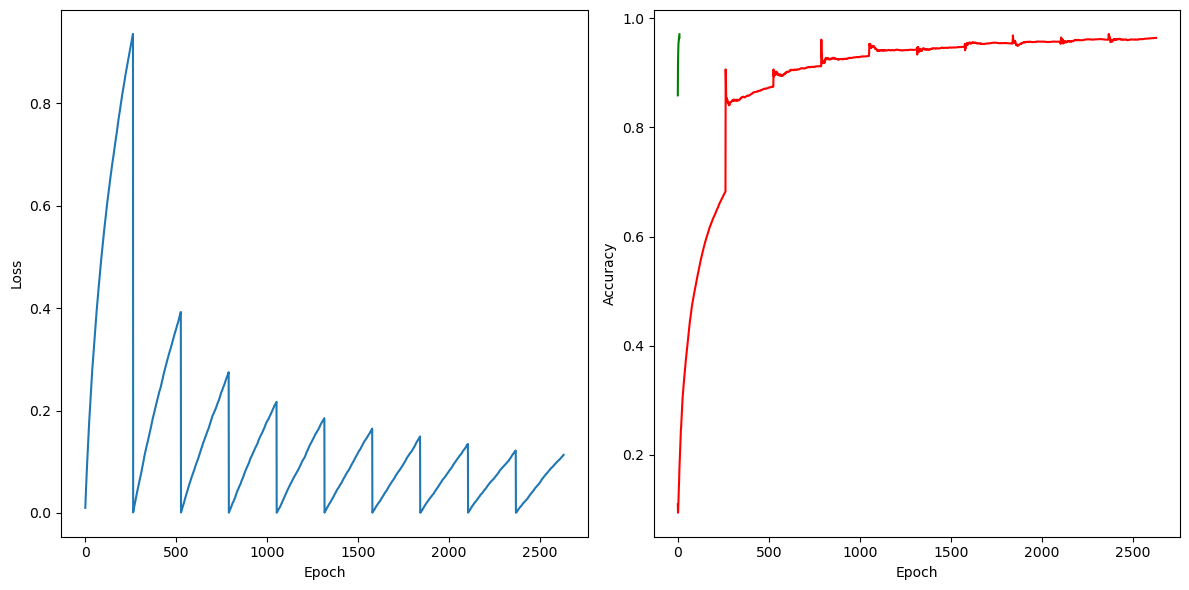

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(loss_history)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
        
axes[1].plot(accuracy_history["train"], color="red", label="Train")
axes[1].plot(accuracy_history["valid"], color="green", label="Valid")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
        
plt.tight_layout()
plt.show()

In [19]:
chk = OUTPUT_PATH / f"bb_resnet18_{best_acc:.5f}.pth" # Path to the weight file in pth format
sim_model.load_state_dict(torch.load(chk), strict=False)
sim_model.eval()

DataParallel(
  (module): SimpleClassifier(
    (model): ResNet(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1)

In [20]:
sample_submission = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")

In [21]:
sample_submission

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


In [22]:
test_data.shape

(28000, 784)

In [23]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [24]:
def preprocess(image, transform):
    image = image.reshape(28, 28) / 255.0
    image = trans(image)
    image = image.to(torch.float32)
    
    return image

In [25]:
sim_model.to(device)

with torch.no_grad():
    for idx, image in tqdm(test_data.iterrows(), total=len(test_data), desc="Submitting..", colour="blue"):
        image = preprocess(image.values, data_transform)
        output = sim_model(image.unsqueeze(0))
        pred = torch.argmax(output).item()
        
        sample_submission["Label"][idx] = pred

Submitting..: 100%|██████████| 28000/28000 [04:42<00:00, 99.28it/s] 


In [26]:
sample_submission.to_csv("/kaggle/working/submission_128_10.csv", index=False)

#### Removing images or files

In [27]:
# import shutil
# import os

# def remove_folder(path):
#     # Check if the folder exists
#     if os.path.exists(path):
#         # Remove the folder
#         shutil.rmtree(path)
#     else:
#         print(f"The folder {path} does not exist")

# # Example usage
# remove_folder('/kaggle/working/weights')


# # Define the path to the file you want to delete
# file_path = '/kaggle/working/submission.csv'

# # Check if the file exists
# if os.path.exists(file_path):
#     # Remove the file
#     os.remove(file_path)
# else:
#     print(f"The file {file_path} does not exist")